# 목적
* 텐서플로우 2로 integrated gradients [(논문)](https://arxiv.org/abs/1703.01365)를 구현해보자.
* 텐서플로우 2 공식 튜토리얼 : [링크](https://www.tensorflow.org/tutorials/interpretability/integrated_gradients)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time

%matplotlib inline

In [2]:
print(tf.__version__)
print(tfds.__version__)

2.3.1
4.1.0


## 상수

In [3]:
EPOCHS = 3
BATCH_SIZE = 2**3

## 데이터 준비

In [4]:
ds = tfds.load('imagenette/160px-v2')

In [57]:
X_train, y_train = [], []
for x in ds['train']:
    img = np.array(Image.fromarray(x['image'].numpy()).resize((160,160)))
    X_train.append(img)
    y_train.append(x['label'])
    
X_test, y_test = [], []
for x in ds['validation']:
    img = np.array(Image.fromarray(x['image'].numpy()).resize((160,160)))
    X_test.append(img)
    y_test.append(x['label'])
    
X_train = np.array(X_train) / 255.
y_train = np.array(y_train)

X_test = np.array(X_test) / 255.
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(9469, 160, 160, 3) (9469,)
(3925, 160, 160, 3) (3925,)


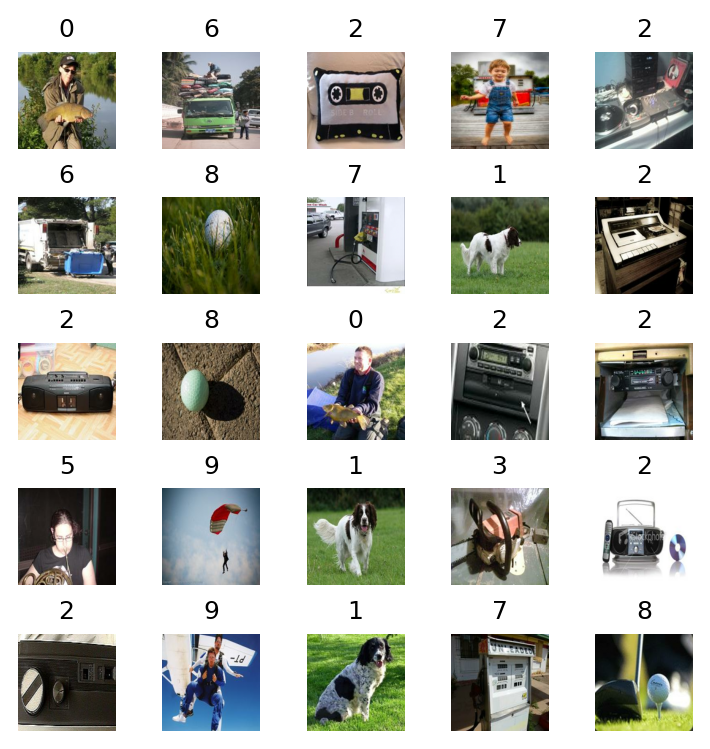

In [6]:
np.random.seed(0)
nrows, ncols = 5, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(5,5), dpi=180)
for i in range(nrows):
    for j in range(ncols):
        idx = np.random.randint(X_train.shape[0])
        ax[i][j].imshow(X_train[idx])
        ax[i][j].set_title(str(y_train[idx]), fontsize=10)
        ax[i][j].axis('off')
plt.subplots_adjust(hspace=.5)
plt.show()

In [7]:
train_dataset = tf.data.Dataset.\
            from_tensor_slices((X_train, y_train)).\
            shuffle(True).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.\
            from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

## 모델 불러오기

In [8]:
from tensorflow.keras import models, layers, losses, optimizers, metrics

In [9]:
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=(160,160,3), include_top=False, weights='imagenet')

for layer in mobilenetv2.layers:
    if layer.trainable == True:
        layer.trainable = False
        
class Model(models.Model):
    def __init__(self,base_model):
        super(Model,self).__init__()
        self.base_model = base_model
        self.top_layer = models.Sequential([
            layers.Dense(10),
            layers.Activation(tf.nn.softmax),
        ])
        
    def call(self,inputs,training=False):
        x = self.base_model(inputs, training=training)
        x = layers.Flatten()(x)
        outputs = self.top_layer(x, training=training)
        return outputs
        
model = Model(mobilenetv2)
model.build((None, 160, 160, 3))

In [10]:
opt = optimizers.Adam(learning_rate=1e-4)
scc = losses.SparseCategoricalCrossentropy()
metric = metrics.SparseCategoricalAccuracy()
loss = metrics.Mean()
acc = metrics.Mean()

In [11]:
%%time
for e in range(EPOCHS):
    start = time.time()
    for inputs in train_dataset:
        _x, _y = inputs
        with tf.GradientTape() as t:
            _y_pred = model(_x)
            _loss = scc(_y, _y_pred)
        grads = t.gradient(_loss, model.trainable_variables)
        opt.apply_gradients(list(zip(grads, model.trainable_variables)))
        loss.update_state(_loss)
        acc.update_state(metric(_y, _y_pred))
    print(f"{e+1}/{EPOCHS} loss:{loss.result():.8f} acc:{acc.result()*100:.2f}% {time.time()-start:.2f} sec/epoch")
    loss.reset_states()
    acc.reset_states()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



1/3 loss:0.23007312 acc:88.03% 64.86 sec/epoch
2/3 loss:0.01450758 acc:95.36% 64.47 sec/epoch
3/3 loss:0.00277118 acc:97.21% 63.98 sec/epoch
CPU times: user 2min 53s, sys: 5.12 s, total: 2min 58s
Wall time: 3min 13s


In [12]:
acc.reset_states()

for inputs in test_dataset:
    _x, _y = inputs
    _y_pred = model(_x)
    acc.update_state(metric(_y, _y_pred))
    
print(f"{acc.result()*100:.2f}%")

97.65%


## Integrated Gradients

integrated gradients 는 아래 식과 같이 나타낼 수 있다.
$$
\text{IntegratedGradients}_i (x) := (x_i -x_i') \times \int^1_{\alpha=0} \frac{\partial F \big( x' + \alpha \times (x - x') \big)}{\partial x_i} d\alpha
$$

이 때,
* $x$ : 입력하는 이미지
* $x'$ : baseline 이미지 (0으로만 채워진 매트릭스. 그림 찍어보면 검은색)
* $F$ : 딥러닝 모델
* $\alpha$ : baseline 이미지와 입력 이미지를 내분하는 점을 만들어주는 놈
* $i$ : 픽셀 번호 (텐서 차원)

baseline 은 아래와 같이 만들어볼 수 있다.

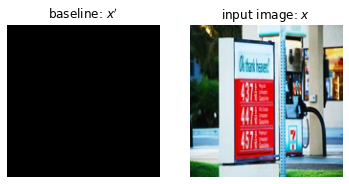

In [58]:
np.random.seed(0)
x = X_test[np.random.randint(len(X_test))]
baseline = np.zeros(x.shape)

fig, ax = plt.subplots(1,2)
ax[0].imshow(baseline)
ax[0].set_title(f'baseline: $x\'$')
ax[1].imshow(x)
ax[1].set_title(f"input image: $x$")
for i in range(2):
    ax[i].axis('off')
plt.show()

위에서 정의한 방법은 적분이 들어가 있다. 컴퓨터로 계산 못하니 integrated gradients 를 아래와 같이 근사해서 풀이한다.

$$
\text{IntegratedGradients}_i^{approx}(x) := (x_i - x'_i) \times \sum_{k=1}^m \frac{\partial F \big(x' + {k \over m}  \times (x-x')\big)}{\partial x_i} \times {1 \over m}
$$

이 때,
* $m$ : 리만 근사 적분 (Riemman approximation of integral) 하기 위한 쪼개는 개수 (고등학교에서 적분 배울 때, 그래프 아래를 잘개 쪼개서 했던 거 생각해보면 됨)

위 정의를 요소별로 직관적으로 이해해보자면

* $(x_i - x_i')$ : 입력 이미지 $x$ 랑 $x'$ 의 픽셀 마다 차이. 근데 baseline 을 모두 0으로 두면 걍 입력 이미지 $x$ 그 자체가 됨 (때에 따라 baseline을 모두 max값으로 채우거나 무작위 값으로 채우는 경우가 있어서 일반적인 정의를 하려고 저렇게 해둠)
* summation 안쪽을 보면,
  * 분자는 그냥 baseline $x'$ 과 입력 이미지 $x$ 사이의 내분 값을 $k=1$ 부터 $k=m$ 까지 차례대로 넣자는 의미임. 즉, 아래와 같이 내분 이미지를 스텝별로 나타내보면

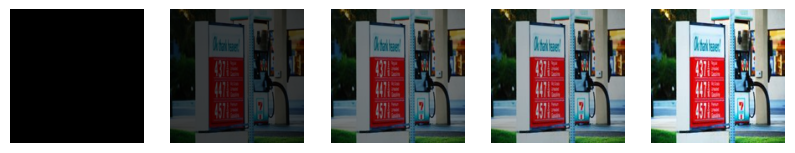

In [79]:
m = 5
alpha = np.linspace(0., float(m), num=m)

img_segment = lambda k: baseline + k / m * (x - baseline)

fig, ax = plt.subplots(1, m, figsize=(m*2,2), dpi=100)
for k in range(m):
    img = img_segment(alpha[k])
    ax[k].imshow(img)
    ax[k].axis('off')
plt.show()

* 이어서...
  * 그래서 분자는 저 이미지들을 딥뉴럴넷 $F$ 에 넣은 상태로
  * 분모 $x_i$ 즉, 입력 이미지 $x$ 의 $i$ 번째 픽셀로 미분하겠다는 것임

* 다시 summation 으로 나와서, 미분한 놈들의 값을 픽셀의 방향(axis) 로 합산해주면 됨
* 따라서 정의대로 하면 $i$ 번째 차원 마다 scalar 값이 나온다.

In [137]:
F_sum = None
x = tf.expand_dims(tf.squeeze(x), axis=0)

for k in range(m):
    with tf.GradientTape() as t:
        t.watch(x)
        F_segment = model(img_segment(alpha[k]))
        grads = t.gradient(F_segment, x)
        if F_sum is not None:
            F_sum += grads
        else:
            F_sum = grads
       
assert x.shape == F_sum.shape
IG = tf.multiply(x, F_sum)
IG.shape

TensorShape([1, 160, 160, 3])

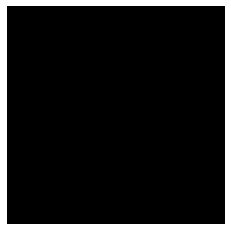

In [138]:
plt.imshow(np.squeeze(IG))
plt.axis('off')
plt.show()

모델이 맞춤? True
그레디언트 합계 최소/최대: 0.0 0.0
모델이 맞춤? False
모델이 맞춤? False
모델이 맞춤? True
그레디언트 합계 최소/최대: 0.0 0.0
모델이 맞춤? False
모델이 맞춤? True
그레디언트 합계 최소/최대: -6.979010804035868e-08 5.3578756321569065e-08


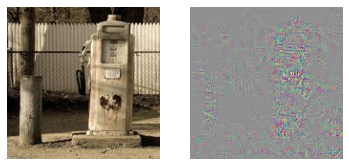

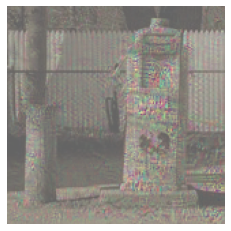

모델이 맞춤? True
그레디언트 합계 최소/최대: -6.282257657528368e-08 5.2977838509230134e-08


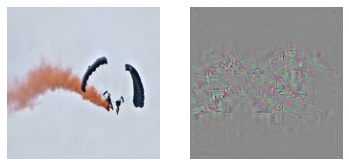

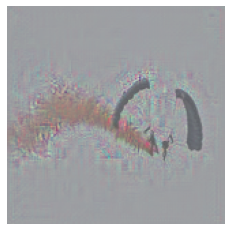

모델이 맞춤? True
그레디언트 합계 최소/최대: -4.13927252526157e-08 5.206271581362252e-08


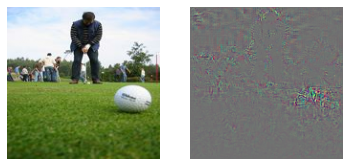

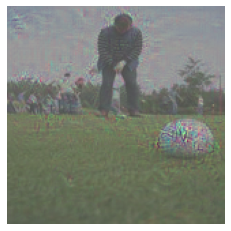

모델이 맞춤? True
그레디언트 합계 최소/최대: -3.8075515678631055e-08 4.017221703544121e-08


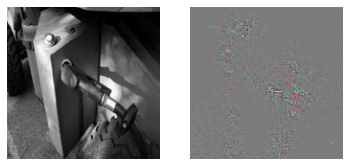

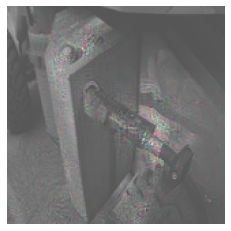

모델이 맞춤? True
그레디언트 합계 최소/최대: -2.643644947242859e-08 3.37538441432544e-08


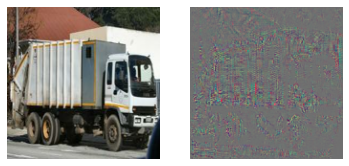

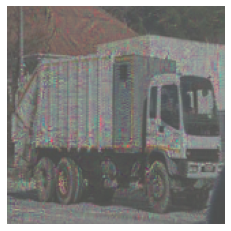

모델이 맞춤? True
그레디언트 합계 최소/최대: 0.0 0.0
모델이 맞춤? True
그레디언트 합계 최소/최대: 0.0 0.0
모델이 맞춤? True
그레디언트 합계 최소/최대: -5.747780345272453e-08 8.069233092778721e-08


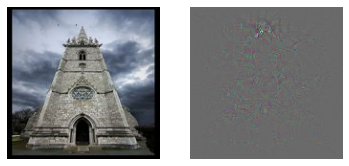

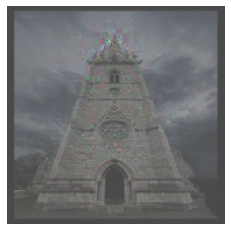

모델이 맞춤? True
그레디언트 합계 최소/최대: 0.0 0.0
모델이 맞춤? True
그레디언트 합계 최소/최대: -4.433471193883603e-08 2.432749632784723e-08


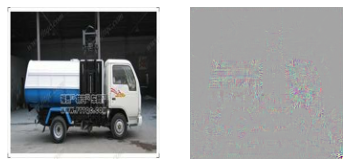

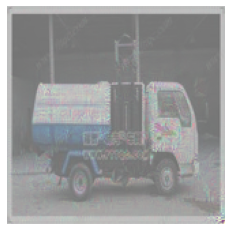

모델이 맞춤? True
그레디언트 합계 최소/최대: 0.0 0.0
모델이 맞춤? True
그레디언트 합계 최소/최대: 0.0 0.0
모델이 맞춤? True
그레디언트 합계 최소/최대: -1.6054500019791765e-07 1.7054616501197232e-07


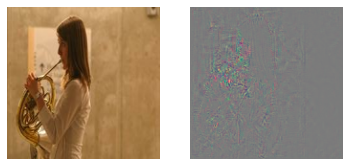

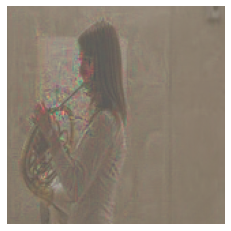

모델이 맞춤? True
그레디언트 합계 최소/최대: 0.0 0.0
모델이 맞춤? True
그레디언트 합계 최소/최대: 0.0 0.0
모델이 맞춤? True
그레디언트 합계 최소/최대: -6.735521714694593e-08 6.022629530213707e-08


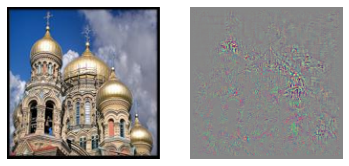

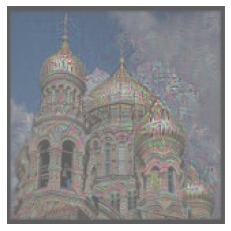

모델이 맞춤? True
그레디언트 합계 최소/최대: 0.0 0.0
모델이 맞춤? True
그레디언트 합계 최소/최대: 0.0 0.0
모델이 맞춤? True
그레디언트 합계 최소/최대: -2.510382559935183e-08 2.775821409765437e-08


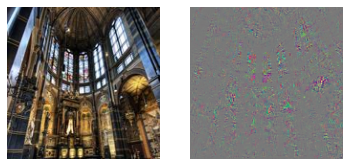

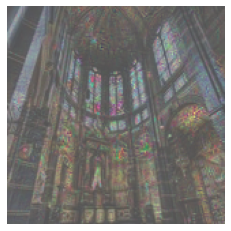

모델이 맞춤? True
그레디언트 합계 최소/최대: 0.0 0.0
모델이 맞춤? True
그레디언트 합계 최소/최대: -8.034420020789293e-08 7.158370560015707e-08


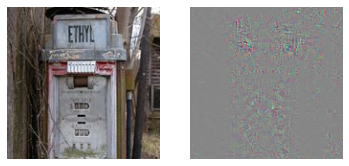

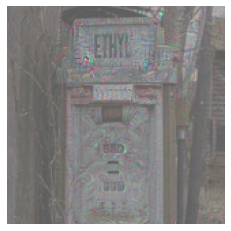

모델이 맞춤? True
그레디언트 합계 최소/최대: 0.0 0.0
모델이 맞춤? True
그레디언트 합계 최소/최대: 0.0 0.0
모델이 맞춤? True
그레디언트 합계 최소/최대: 0.0 0.0
모델이 맞춤? True
그레디언트 합계 최소/최대: 0.0 0.0


In [212]:
def IntegratedGradients(x, y, m):
    img_segment = lambda k: baseline + k / m * (x - baseline)

    _alpha = np.linspace(0., float(m), num=m)
    _F_sum = None
    x = tf.expand_dims(tf.squeeze(x), axis=0)

    for _k in range(m):
        with tf.GradientTape() as t:
            t.watch(x)
            _F_segment = model(img_segment(_alpha[k]))
            _grads = t.gradient(_F_segment, x) / m
            if _F_sum is not None:
                _F_sum = tf.math.add(_F_sum, _grads)
            else:
                _F_sum = _grads
                
    print('모델이 맞춤?',y == np.argmax(_F_segment[0]))
    if y == np.argmax(_F_segment[0]):
        assert x.shape == _F_sum.shape
        IG = tf.multiply(x, _F_sum)
        
        print('그레디언트 합계 최소/최대:',np.min(IG), np.max(IG))
        if np.min(IG) != np.max(IG):
            IG = (IG - np.min(IG)) / (np.max(IG) - np.min(IG))

            fig, ax = plt.subplots(1,2)
            ax[0].imshow(np.squeeze(x))
            ax[0].axis('off')
            ax[1].imshow(np.squeeze(IG))
            ax[1].axis('off')
            plt.show()

            plt.imshow(np.squeeze(x))
            plt.imshow(np.squeeze(IG), alpha=.7)
            plt.axis('off')
            plt.show()

# 잘 되는 결과만 좀 출력해보기
for _ in range(30):
    idx = np.random.randint(len(X_test))
    x = X_test[idx]
    y = y_test[idx]
    IntegratedGradients(x=x, y=y, m=10)